# Elevation Covariate

Read elevation data by a bounding box tile for stacking with other covariates in analysis.
Initial version uses SRTM v3 available as Cloud Optimized Geotiffs in MAAP.

##### step 1: get bbox of tile
##### step 2: buffer/extend bbox at min 1 pixel (can be more, no prob)
##### step 3: read the elev data
##### step 4: clip and write_band for elev
##### step 5: compute the 3 covars in memory with for loop; for covar in covars: calc, clip, write_band

In [26]:
#only run this block if needed in a new workspace
%pip install -q rasterio
%pip install -q geopandas
%pip install -q folium

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [31]:
import json
import os
import rasterio as rio
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg
from rasterio.mask import mask
from rasterio.warp import *
from rasterio.merge import merge
from rasterio import windows
import numpy as np
import matplotlib.pyplot as plt
#import rioxarray as rxr

import sys

from maap.maap import MAAP
maap = MAAP()
from pprint import pprint

### Get the bbox of the tile

In [67]:
# Get bbox extent
geojson_path = '/projects/maap-users/alexdevseed/boreal_tiles_latlong.geojson'
bbox_ID = 40349
#in_crs = CRS.from_epsg(4326)

# open geojson and get co-ords of tile ID
with open(geojson_path) as j:
    response = json.load(j)
    in_bbox = rio.features.bounds(response['features'][bbox_ID-1]['geometry'])

converted_in_bbox = ",".join([str(element) for element in in_bbox])
print(converted_in_bbox)

-117.6,50.6,-117.3,50.9


In [68]:
# generated from this EDSC search: https://ade.maap-project.org:30052/search/granules?p=C1200271393-NASA_MAAP&q=SRTM&tl=1598404169!4!!
collection_info = maap.searchCollection(concept_id="C1200271393-NASA_MAAP", limit=1000)

In [69]:
short_name = collection_info[0]['Collection']['ShortName']
pprint(short_name)

'SRTMGL1_COD'


In [71]:
granule_results = maap.searchGranule(short_name=short_name, bounding_box=converted_in_bbox , limit=20)

In [90]:
len(granule_results)
#granule_results[0]

1

## Inspect the results


In [73]:
import geopandas as gpd
import folium
import shapely as shp
import folium

In [74]:
def make_polygons(item):
    bounds = item['Granule']['Spatial']['HorizontalSpatialDomain']['Geometry']['BoundingRectangle']
    item_bbox = [float(value) for value in bounds.values()]
    bbox_polygon = shp.geometry.box(
        item_bbox[0], 
        item_bbox[1],
        item_bbox[2], 
        item_bbox[3]
    )
    return bbox_polygon

In [75]:
# Make a footprint of the tif tiles returned in the granule results
geometries = gpd.GeoSeries([make_polygons(item) for item in granule_results], crs='EPSG:4326')
geometries

0    POLYGON ((-116.99972 51.00028, -116.99972 49.9...
dtype: geometry

In [133]:
# Reformat bbox
bbox_list =  [float(value) for value in converted_in_bbox.split(',')]

# Elevation covar calc will require consideration of tile edges. We want seemlessness across adjacent tiles
# To handle this, use this buffered bbox to extract elevation data, process it to the covars, then clip by original bbox
bbox_buffered = shp.geometry.box(*bbox_list).buffer(distance = 0.001)

# TODO: Probably need a 'bbox_buffered_list' from the above geometry...
print(bbox_buffered)

# Get centroid of bbox
center = shp.geometry.box(*bbox_list).centroid

m = folium.Map(
    # Zoom to center
    #location=[center.y,center.x],
    # Zoom to corner
    location=[bbox_list[1], bbox_list[0]],
    tiles="cartodbpositron",
    zoom_start=15,
)

bbox_style = {'fillColor': '#ff0000', 'color': '#ff0000'}
bbox_buf_style = {'fillColor': '#fdae61', 'color': '#fdae61'}

folium.GeoJson(geometries, name="tiles").add_to(m)
folium.GeoJson(shp.geometry.box(*bbox_list), 
               name="bbox",
               style_function=lambda x:bbox_style).add_to(m)
folium.GeoJson(bbox_buffered, 
               name="bbox_buf",
               style_function=lambda x:bbox_buf_style).add_to(m)
m

POLYGON ((-117.3 50.599, -117.6 50.599, -117.6000980171403 50.59900481527333, -117.600195090322 50.5990192147196, -117.6002902846772 50.59904305966427, -117.6003826834324 50.59907612046749, -117.6004713967368 50.59911807873565, -117.600555570233 50.5991685303877, -117.6006343932842 50.59922698954664, -117.6007071067812 50.59929289321882, -117.6007730104534 50.59936560671584, -117.6008314696123 50.59944442976698, -117.6008819212643 50.59952860326317, -117.6009238795325 50.59961731656764, -117.6009569403357 50.59970971532275, -117.6009807852804 50.59980490967799, -117.6009951847267 50.59990198285967, -117.601 50.6, -117.601 50.9, -117.6009951847267 50.90009801714033, -117.6009807852804 50.90019509032201, -117.6009569403357 50.90029028467725, -117.6009238795325 50.90038268343236, -117.6008819212643 50.90047139673683, -117.6008314696123 50.90055557023302, -117.6007730104534 50.90063439328416, -117.6007071067812 50.90070710678118, -117.6006343932842 50.90077301045336, -117.600555570233 50.9

### Read the elevation data (for the bbox)

For each result read the subwindow. After reading all the subwindows, merge them together as a single  array. 

Q: is it easier to make a vrt of the files and then request the subwindow, or does that waste time?

In [96]:
import rasterio as rio
from rasterio.merge import merge
from rasterio.session import AWSSession 
from rasterio.plot import show
import boto3
from matplotlib.pyplot import imshow
import numpy as np
import numpy.ma as ma
from pyproj import Proj, Transformer

def hillshade(array,azimuth,angle_altitude):
    azimuth = 360.0 - azimuth 

    x, y = np.gradient(array)
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azimuthrad = azimuth*np.pi/180.
    altituderad = angle_altitude*np.pi/180.

    shaded = np.sin(altituderad)*np.sin(slope) + np.cos(altituderad)*np.cos(slope)*np.cos((azimuthrad - np.pi/2.) - aspect)

    return 255*(shaded + 1)/2

def plot_band_array(band_array,refl_extent,title,cbar_label,colormap='spectral',alpha=1):
    plt.imshow(band_array,extent=refl_extent,alpha=alpha); 
    cbar = plt.colorbar(); plt.set_cmap(colormap); 
    cbar.set_label(cbar_label,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation #
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degree

In [80]:
# Set up and aws session
aws_session = AWSSession(boto3.Session())
# Get the s3 urls to the granules
file_s3 = [item['Granule']['OnlineAccessURLs']['OnlineAccessURL']['URL'] for item in granule_results] 
file_s3.sort()
file_s3


['s3://cumulus-map-internal/file-staging/nasa-map/SRTMGL1_COD___001/N50W118.SRTMGL1.tif']

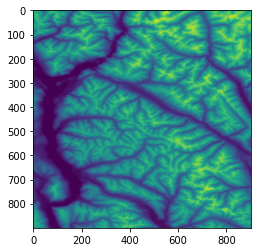

<AxesSubplot:>

In [82]:
# prove that we can read the aws files, an overview should be faster
# https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
with rio.Env(aws_session):
    with rio.open(file_s3[0], 'r') as src:
        # List of overviews from biggest to smallest
        oviews = src.overviews(1)

        # Retrieve the smallest thumbnail
        oview = oviews[1]
        thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))

show(thumbnail)

In [85]:
# Create a mosaic from all the images
with rio.Env(aws_session):
    sources = [rio.open(raster) for raster in file_s3]

In [86]:
# Merge the source files
# TODO: test passing all s3 sources
mosaic, out_trans = merge(sources, bounds = bbox_list)

In [99]:
# Mask the NoData values so it can be plotted correctly
from osgeo import gdal
masked_mosaic = ma.masked_values(mosaic, int(sources[0].nodatavals[0]))
# TODO: gdal wants a dataset i think, not a masked array...
hs = hillshade(masked_mosaic, 315, 25)
#show(hs, cmap = 'gray') 

ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

### Write Results as Cloud Optimized Geotiff (Optional)
This step is included just to demonstrate writing the results to file for use in a later processing step.

In [88]:
# Functions copied from 3.1.2
# TODO: create library of functions used acrosss notebooks
def define_raster(file, in_bbox, epsg="epsg:4326"):
    '''Read the first raster to get its transform and crs'''
    with rio.open(file, 'r') as f:
        bbox = transform_bounds(epsg, f.crs, *in_bbox)
        #w = windows.from_bounds(*bbox, transform=f.transform)
        #band = f.read(1, window=w, masked=True)
        band, out_transform = merge([f],bounds=bbox)
    return f.crs, out_transform
        
def MaskArrays(file, in_bbox, epsg="epsg:4326"):
    '''Read a window of data from the raster matching the tile bbox'''
    print(file)
    with rio.open(file, 'r') as f:
        bbox = transform_bounds(epsg, f.crs, *in_bbox)
        #w = windows.from_bounds(*bbox, transform=f.transform)
        #band = f.read(1, window=w, masked=True)
        band, out_transform = merge([f],bounds=bbox)
    return np.ma.masked_array(band[0].astype(float), mask=f.nodata)

def Write_to_disk(comp_stack, out_name):
    print("Writing to disk: {}".format(out_name))
    #TODO: full COG writing: higher compression, overviews, tile size, nodata
    kwargs=({'driver':'GTiff',
             'height':comp_stack.shape[0],
             'width':comp_stack.shape[1],
             'count':comp_stack.shape[2],
             'dtype':comp_stack.dtype,
             'crs':out_crs,
             'transform':out_transform,   #<--- TODO: should 'out_transform' be an input to this function?
             'compress':'deflate'
            })
    with rasterio.open(out_name, 'w', **kwargs) as dst:
        dst.write(np.moveaxis(comp_stack, [0, 1, 2], [2, 1, 0]))

In [19]:
# TODO: format outname correctly to coincide with Landsat covars
data_path = "/projects/maap-users/username/"
tileid = "example"
ext = "_dem.tif"
dem_cog_fn = os.path.join(data_path, ".".join([tileid, ext]))
# TODO: 
#define_raster()
#Write_to_disk(masked_mosaic, dem_cog_fn)

### Derive topographic covariates from DEM
This step uses gdaldem to access the DEM COG, calc a topo covar, and write each covariate to a separate COG

In [22]:
import os
# Format elev covar names
# example path

slope_cog_fn = "".join(os.path.splitext(dem_cog_fn)[0], '_slope.tif')
tpi_cog_fn   = "".join(os.path.splitext(dem_cog_fn)[0], '_tpi.tif')
tsri_cog_fn  = "".join(os.path.splitext(dem_cog_fn)[0], '_tsri.tif')

In [ ]:
from osgeo import gdal

def make_tsri(elevation, tsri_cog_fn):
    # TSRI
    # topo solar radiation index (a transformation of aspect; 0 - 1) TSRI = 0.5−cos((π/180)(aspect−30))/2
    # Matasci et al 2018: https://doi.org/10.1016/j.rse.2017.12.020
    # Use gdaldem API to handle tmp aspect calc in memory
    # Aspect is an intermediate step before calc'ing TSRI. Should we hold it in memory?
    print("Calculating Aspect from masked dem mosaic...")
    aspect = gdal.DEMProcessing('', elevation, 'aspect', format='MEM')

    tsri = 0.5 − np.cos((np.pi/180.)(aspect − 30.))/2.
    Write_to_disk(tsri, tsri_cog_fn)

make_tsri(masked_mosaic, tsri_cog_fn)

In [ ]:
## Paul - This assumes we've written the elevation to disk
# @Alex - is this more like what we'll want?
if dem_cog_fn.is_file():
    # Call gdaldem at cmd line to read in the elev file on disk
    # Slope
    # Use gdaldem command line tool to handle elev covar calcs
    # https://gdal.org/drivers/raster/cog.html
    # -compute_edges
    !gdaldem slope -of COG -zero_for_flat $dem_cog_fn $slope_cog_fn

    # TPI
    # topo position index (a measure of local concavity/convexity; -1 1) gdaldem TPI
    # -compute_edges
    !gdaldem tpi -of COG $dem_cog_fn $tpi_cog_fn
else:
    if hasattr(masked_mosaic, 'shape'): 
        print("Calculating Slope from masked dem mosaic...")
        slope = gdal.DEMProcessing('', elevation, 'slope', format='MEM')
        Write_to_disk(slope, slope_cog_fn)
        print("Calculating TPI from masked dem mosaic...")
        tpi = gdal.DEMProcessing('', elevation, 'tpi', format='MEM')
        Write_to_disk(tpi, tpi_cog_fn)
    else:
        print("Cannot calculate slope and TPI.\n{} is not written to disk and its array does not exist.".format(dem_cog_fn))